# **Final submission**
---
This document contains our final submission. The model has two parts - one part for preprocessing images with a face detector, and one part which translates the images into medieval portraits. These parts are separated throughout the code so that we can describe their functionalities independently.



**Sources**:
- The source webpage, which we've used to create the face detector can be found [here](https://realpython.com/face-recognition-with-python/).
- [Widerfaces dataset](https://drive.google.com/drive/folders/0BxYys69jI14kSVdWWllDMWhnN2c) with high quality images of people.



# The first part

In [ ]:
from google.colab import drive
import os
drive.mount("/content/drive")
import cv2
import re
from IPython.display import clear_output

#more convinient workplace
%cd drive/MyDrive/deeplearning/resource 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/deeplearning/resource




---


Here we're unzipping the input images that show regular people. We've realized that these images are not all the best match for this task, so we needed to clean them. As descriped before, we're using a pretrained model here (to preprocess the raw data), so we wont need to train it. 

In [ ]:
#Load the cascade
face_cascade = cv2.CascadeClassifier('face_detector.xml')

#%cd resource
#!unzip face_detection.zip -d input
clear_output(wait=True)
print('images unzipped')

# Load the images
images = [f for f in os.listdir('input')  if f.endswith(".jpg")]
print("Number of input files: {}".format(len(images)))

images unzipped
Number of input files: 1000




---
The last part of our task here is to crop and resize the images, so that they can be fed to the GAN in the second model.

The names of the images that could not be processed (no faces found, or other kind of validation errors) are collected into a single .txt file called **invalid_images.txt** . 

**results of this model can be seen in the gan_input_images folder**

In [ ]:
def crop_and_resize_image(face, img, dim):
  x, y, w, h = face
  abs_min_y = y-h if y-h>=0 else 0
  abs_max_y = y+3*h if y+3*h<= img.shape[0] else img.shape[0]-1
  abs_min_x = x-w if x-w>= 0 else 0
  abs_max_x = x+2*w if x+2*w <= img.shape[1] else img.shape[1] -1
  print(" {} : {} \t {} : {} \n".format(abs_min_y, abs_max_y, abs_min_x,abs_max_x))
  crop_img = img[abs_min_y:abs_max_y, abs_min_x:abs_max_x]
  resized = cv2.resize(crop_img, dim, interpolation = cv2.INTER_AREA)
  return resized

In [ ]:
width = 256
height = 256
def process_image(image_name):
    try:
      img = cv2.imread("input/" + image_name)
      faces = face_cascade.detectMultiScale(img, 1.1, 2)
      if len(faces) >= 1:
        print("{}- {} cropped ".format(cnt, image_name))
        resized = crop_and_resize_image(faces[0], img, (width, height))
        cv2.imwrite("/content/drive/MyDrive/deeplearning/resource/gan_input_images/cropped_" + image_name, resized)     
        clear_output(wait=True)
      
    except:
      f = open("invalid_images.txt", "a+")
      f.write(image_name + "\n")
      f.close()

    clear_output(wait=True)

In [ ]:
cnt = 0
for image in images:
    process_image(image)
    cnt += 1

999- 86_0_0_20170111223837209.jpg cropped 
 0 : 412 	 130 : 460 



#The second part - The GAN, which makes a face into a painting

# Credits

For much of the code, we wanna give credit to tensorflow https://www.tensorflow.org/tutorials/generative/cyclegan
We tried to improve on it in some ways, unfortunately our results were not bested, so the code is really similar to the original still.

# Settings

Mounting the drive, imports, installations

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

In [ ]:
from google.colab import drive
%cd /content
drive.mount('/content/drive')

/content
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip /content/drive/MyDrive/deeplearning/resource/painting.zip -d /content/drive/MyDrive/deeplearning/resource/

Archive:  /content/drive/MyDrive/deeplearning/resource/painting.zip
replace /content/drive/MyDrive/deeplearning/resource/painting/test/paolo-uccello_a-young-lady-of-fashion.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
%cd /content
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -U tensorflow-addons

/content


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

from tensorflow_addons.layers import InstanceNormalization
from keras.optimizers import Adam
from keras.models import Model, Input
from keras.layers import Conv2D, Conv2DTranspose, Activation, Concatenate
from keras.initializers import RandomNormal
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.utils.vis_utils import plot_model

import math
from tqdm.autonotebook import tqdm
import numpy as np
import scipy

AUTOTUNE = tf.data.AUTOTUNE

#DataSets

First we make 4 data sets. Training and testing for both faces and paintings.

In [ ]:
def decode_img(file_path):
    file = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(file, channels=3)
    img = tf.image.resize(img, [256, 256])
    return img

img_path = "/content/drive/MyDrive/deeplearning/resource/input/"
ds_train_paths = tf.data.Dataset.list_files(str(img_path + '*.jpg'))
ds_train_face = ds_train_paths.map(decode_img)

img_path = "/content/drive/MyDrive/deeplearning/resource/painting/train/"
ds_train_paths = tf.data.Dataset.list_files(str(img_path + '*.jpg'))
ds_train_painting = ds_train_paths.map(decode_img)

img_path = "/content/drive/MyDrive/deeplearning/resource/gan_input_images/"
ds_test_paths = tf.data.Dataset.list_files(str(img_path + '*.jpg'))
ds_test_face = ds_test_paths.map(decode_img)

img_path = "/content/drive/MyDrive/deeplearning/resource/painting/test/"
ds_test_paths = tf.data.Dataset.list_files(str(img_path + '*.jpg'))
ds_test_painting = ds_test_paths.map(decode_img)

The batch size remained 1 unfortunately, because the GPU couldn't handle more (OOM = Out Of Memory exception). The buffer size means only, that the images in the datasets were shuffled per 1000 image.

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

Here we implement some image preparation methods, like cropping, normalizing and adding jitter.

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
def preprocess_image_train(image):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [ ]:
def preprocess_image_test(image):
  image = normalize(image)
  return image

Here is the final step for completing the dataset preparation. We make the data sets into Tensorflow Datasets.

In [ ]:
ds_train_face = ds_train_face.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

ds_train_painting = ds_train_painting.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

ds_test_face = ds_test_face.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

ds_test_painting = ds_test_painting.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In the next few cells there are plots, so we know, what we are working with.

In [ ]:
sample_faces = next(iter(ds_train_face))
sample_paintings = next(iter(ds_train_painting))

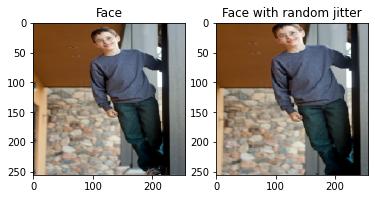

In [ ]:
plt.subplot(121)
plt.title('Face')
plt.imshow(sample_faces[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Face with random jitter')
plt.imshow(random_jitter(sample_faces[0]) * 0.5 + 0.5)

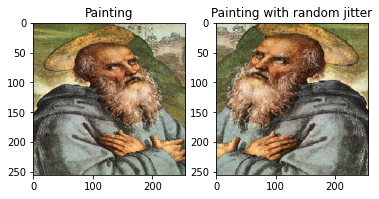

In [ ]:
plt.subplot(121)
plt.title('Painting')
plt.imshow(sample_paintings[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Painting with random jitter')
plt.imshow(random_jitter(sample_paintings[0]) * 0.5 + 0.5)

We leave the next cell here, though it is unnecessary for running the code. It was a try to improve with resnet, but unfortunately it did not improve the results.

In [ ]:
def resnet_block(n_filters, input_layer):
	init = RandomNormal(stddev=0.02)
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Concatenate()([g, input_layer])
	return g
 
# define the standalone generator model
def define_generator(image_shape=(256,256,3), n_resnet=9):
	init = RandomNormal(stddev=0.02)
	in_image = Input(shape=image_shape)
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	for _ in range(n_resnet):
		g = resnet_block(256, g)

	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)

	model = Model(in_image, out_image)
	return model

We could have make the model hand-by-hand, but the result would be the same, so we are using the pix2pix's model, to define our model's parts.

In [ ]:
generator_g = pix2pix.unet_generator(3, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(3, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


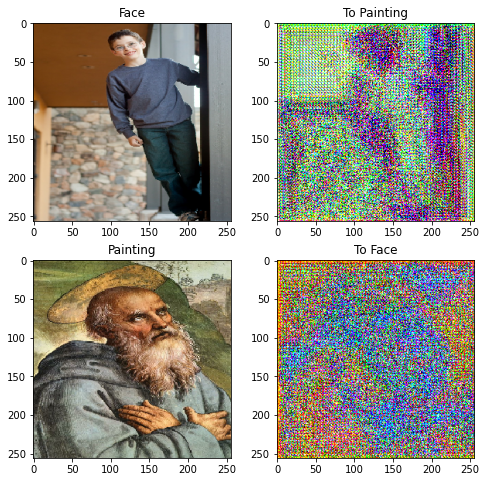

In [ ]:
to_painting = generator_g(sample_faces)
to_face = generator_f(sample_paintings)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_faces, to_painting, sample_paintings, to_face]
title = ['Face', 'To Painting', 'Painting', 'To Face']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

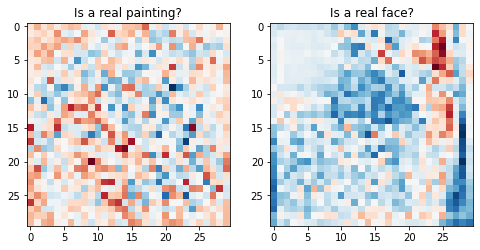

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real painting?')
plt.imshow(discriminator_y(sample_paintings)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real face?')
plt.imshow(discriminator_x(sample_faces)[0, ..., -1], cmap='RdBu_r')

plt.show()

#Losses

These are our losses. There are many more, than usually, but the CycleGAN doesn't work without that.

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

#Checkpoint

Saving mechanism, so we can use the model later.

In [ ]:
checkpoint_path = "/content/drive/MyDrive/deeplearning/gan_chkpoint"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print("Restored from {}".format(ckpt_manager.latest_checkpoint))
  print ('Latest checkpoint restored!!')

Only 40 epochs, because before it could end, Colab disconnects from the runtime.

In [ ]:
EPOCHS = 40

#Training

For training (and evaluation) we generate some images. Looking at them periodically tells us, how the training goes.

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Simple implemetation of one train step.

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

The trianing itself. We have to be careful about our drive, because one checkpoint is ~1 GB.

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((ds_train_face, ds_train_painting)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_face) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_faces)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

#Testing

Testing means in this case, that we use the images, that were produced in the first part (cv2). We generate some results, so we can look at them.

In [ ]:
# Run the trained model on the test dataset
for inp in ds_test_face.take(5):
  generate_images(generator_g, inp)

#Evaluation

We use the Frechét Inception Distance (FID). The embedder (classifier without the output layer) is an Inception V3 model. We save some results in the drive as well.

In [ ]:
def save_images(model, test_inputs, num):
  i = 0
  for inp in test_inputs.take(num):
    prediction = model(inp)
    tf.io.write_file(f'/content/drive/MyDrive/deeplearning/gan_output/{i}_res.png', tf.image.encode_png(tf.cast((((prediction[0] * 0.5) + 0.5) + 1) * 127.5, tf.uint8)))
    tf.io.write_file(f'/content/drive/MyDrive/deeplearning/gan_output/{i}_res_orgiginal.png', tf.image.encode_png(tf.cast((((inp[0] * 0.5) + 0.5) + 1) * 127.5, tf.uint8)))
    i+=1

In [ ]:
save_images(generator_g, ds_test_face, 10)

In [ ]:
inception_model = tf.keras.applications.InceptionV3(include_top=False, 
                              weights="imagenet", 
                              pooling='avg')

In [ ]:
def compute_embeddings(dataloader, count, generated = False):
    image_embeddings = []

    for _ in tqdm(range(count)):
        images = next(iter(dataloader))
        if generated:
          images = generator_g(images)
        embeddings = inception_model.predict(images)

        image_embeddings.extend(embeddings)

    return np.array(image_embeddings)

count = math.ceil(100/BATCH_SIZE)

# compute embeddings for real images
real_image_embeddings = compute_embeddings(ds_test_painting, count)

# compute embeddings for generated images
generated_image_embeddings = compute_embeddings(ds_test_face, count, generated = True)

real_image_embeddings.shape, generated_image_embeddings.shape

In [ ]:
def calculate_fid(real_embeddings, generated_embeddings):
  # calculate mean and covariance statistics
  mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
  mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings,  rowvar=False)
  # calculate sum squared difference between means
  ssdiff = np.sum((mu1 - mu2)**2.0)
  # calculate sqrt of product between cov
  covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
  # check and correct imaginary numbers from sqrt
  if np.iscomplexobj(covmean):
    covmean = covmean.real
  # calculate score
  fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

fid = calculate_fid(real_image_embeddings, generated_image_embeddings)

*   Best model (U-NET): 412.0841845577743
*   Res_net model: 552.0247770486873

In [ ]:
fid